In [1]:
using Printf
using LinearAlgebra
using SparseArrays

In [2]:
import PyPlot
const plt = PyPlot

PyPlot

In [3]:
plt.svg(true)
plt.matplotlib.style.use("dark_background")

In [26]:
    seconds_per_yr = 60*60*24*365 # seconds in 1 year
    # physical parameters
    κ  = 1.0e-6    # thermal diffusivity, m^2/s
    Lx = 2.0e3   # width of domain, m
    Ly = 1.0e3     # depth of domain, m
    H  = 0*1e-9  # heat source, o K/s

    Tb = 0.0 # fixed boundary temperature
    Ti = 1.0 # initial temperature

    Ndim = 2
    NelsX = 40
    NelsY = 40
    Nelements = NelsX*NelsY
    #
    NnodesPerElement = 4
    NnodesX = NelsX + 1
    NnodesY = NelsY + 1
    NnodesTotal = NnodesX*NnodesY

    dx = Lx/NelsX   # element length in x-direction
    dy = Ly/NelsY   # element length in y-direction
    
    dt = 10*seconds_per_yr # time step (s)
    Ntime = 60  # number of time steps to perform
    
Ktensor = diagm( 0 => κ*ones(2) ); # thermal diffusivity tensor

In [27]:
g_coord = zeros(Ndim,NnodesTotal)
ip = 0
for i in 1:NnodesX
    for j in 1:NnodesY
        ip = ip + 1
        g_coord[1,ip] = (i-1)*dx
        g_coord[2,ip] = (j-1)*dy
    end
end

In [28]:
# Connectivity matrix
g_num = zeros(Int64, NnodesPerElement,Nelements) 
# grid of global node numbers
gnumbers = reshape( collect(1:NnodesTotal), NnodesY, NnodesX )
iel = 0
# element counter
for i in 1:NelsX
    for j in 1:NelsY
        iel = iel + 1
        g_num[1,iel] = gnumbers[j,i] # local node 1
        g_num[2,iel] = gnumbers[j+1,i] # local node 2
        g_num[3,iel] = gnumbers[j+1,i+1] # local node 3
        g_num[4,iel] = gnumbers[j,i+1] # local node 4
    end
end

In [29]:
    # find boundary nodes
    SMALL_XY = 0.01*min(dx,dy)

    # small fraction of dx or dy
    bx0 = findall(g_coord[1,:] .<= 0.0 + SMALL_XY)  # nodes on x=0 boundary
    bxn = findall(g_coord[1,:] .>= Lx  - SMALL_XY)  # nodes on x=Lx boundary
    by0 = findall(g_coord[2,:] .<= 0.0 + SMALL_XY)  # nodes on y=0 boundary
    byn = findall(g_coord[2,:] .>= Ly  - SMALL_XY)  # nodes on y=Ly boundary

    # define boundary conditions
    bcdof = unique(vcat(bx0, bxn, by0, byn))  # boundary nodes
    Nbcdof = length(bcdof)
    bcval = Tb*ones(Nbcdof)  # boundary temperatures
    println("Nbcdof = ", Nbcdof)

Nbcdof = 160


In [30]:
    NintegPoints = 4
    # gauss integration data
    integPoints = zeros(NintegPoints,Ndim) # location of points
    root3 = 1.0/sqrt(3)
    integPoints[1,1] = -root3; integPoints[1,2] =  root3;
    integPoints[2,1] =  root3; integPoints[2,2] =  root3;
    integPoints[3,1] = -root3; integPoints[3,2] = -root3;
    integPoints[4,1] =  root3; integPoints[4,2] = -root3;
    wIntegPoints = ones(4) # weights

    # save shape functions and their derivatives in local coordinates
    # evaluated at integration points
    fun_s = zeros(NintegPoints,NintegPoints)
    der_s = zeros(Ndim,NintegPoints,NintegPoints)
    der = zeros(Ndim,NintegPoints)
    #
    for k in 1:NintegPoints
        #
        ξ = integPoints[k,1]
        η = integPoints[k,2]
        #
        ηm = 0.25*(1.0 - η)
        ηp = 0.25*(1.0 + η)
        ξm = 0.25*(1.0 - ξ)
        ξp = 0.25*(1.0 + ξ)
        #
        fun = 4*[ ξm*ηm, ξm*ηp, ξp*ηp, ξp*ηm ]
        fun_s[k,:] = fun  # shape functions
        der[1,1] = -ηm
        der[1,2] = -ηp
        der[1,3] =  ηp
        der[1,4] =  ηm
        #
        der[2,1] = -ξm
        der[2,2] =  ξm
        der[2,3] =  ξp
        der[2,4] = -ξp
        der_s[:,:,k] = der # derivatives of shape function
    end
    #for i in 1:NintegPoints
    #    println("\ni = ", i)
    #    display(der_s[:,:,i]); println()
    #end

    # Matrices and vectors
    ff = zeros(Float64, NnodesTotal)  # system load vector
    b = zeros(Float64, NnodesTotal)   # system rhs vector
    LHS = spzeros(Float64, NnodesTotal, NnodesTotal) # system lhs matrix
    RHS = spzeros(Float64, NnodesTotal, NnodesTotal) # system rhs matrix

    #----------------------------------------------------
    # matrix integration and assembly
    #----------------------------------------------------
    KM = zeros(NnodesPerElement,NnodesPerElement)
    MM = zeros(NnodesPerElement,NnodesPerElement)
    F = zeros(NnodesPerElement)
    for iel in 1:Nelements # sum over elements
        num = g_num[:,iel] # element nodes
        coord = g_coord[:,num]' # element coordinates
        KM[:] .= 0.0
        MM[:] .= 0.0
        F[:] .= 0.0
        #
        for k in 1:NintegPoints
            fun = fun_s[k,:]  # shape functions
            der = der_s[:,:,k] # der. of shape functions in local coordinates
            jac = der*coord # jacobian matrix
            detjac = det(jac) # det. of jacobian
            invjac = inv(jac) # inv. of jacobian
            deriv = invjac*der # der. of shape fun. in physical coords.
            #
            KM = KM + deriv'*Ktensor*deriv*detjac*wIntegPoints[k]
            MM = MM + fun*fun'*detjac*wIntegPoints[k]
            F = F + fun*H*detjac*wIntegPoints[k]
        end
        # assemble global matrices and vector
        LHS[num,num] = LHS[num,num] + MM/dt + KM
        RHS[num,num] = RHS[num,num] + MM/dt
        ff[num] = ff[num] + F
    end

In [31]:
LHS

1681×1681 SparseMatrixCSC{Float64, Int64} with 14641 stored entries:
⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷

In [32]:
RHS

1681×1681 SparseMatrixCSC{Float64, Int64} with 14641 stored entries:
⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷

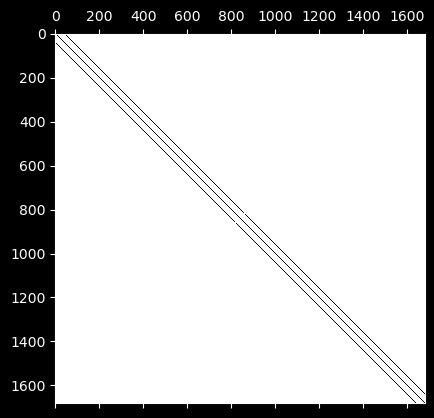

PyObject <matplotlib.image.AxesImage object at 0x7f640ddc6400>

In [33]:
plt.spy(LHS)